# **Stage 3 # Resume-Job Matching and Candidate Ranking**

The notebook focuses on developing and evaluating multiple semantic similarity approaches to compute matching scores between job descriptions and resumes, using a subset of 250 job descriptions and a resume dataset from Kaggle. The core objective is to identify and rank the most relevant resumes for a given job, and vice versa, thereby providing a bidirectional ranking system.

In [ ]:
!python -m spacy download en_core_web_trf
!pip install spacy-transformers
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.6/735.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#=== 1. Setup and Imports === #

import os
import kagglehub
import re
import nltk
import string
import torch
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import kagglehub
import gensim
from gensim import corpora
from gensim.models import LdaModel
from scipy.sparse import issparse
from sklearn.cluster import KMeans


nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
path_for_resume = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print("Path to resume dataset files:", path_for_resume)
# Load Resume Data
resume= pd.read_csv(os.path.join(path_for_resume, 'Resume', 'Resume.csv'))
resume.drop(columns=['Resume_html'], inplace=True)
resume.drop_duplicates(subset=['Resume_str'], inplace=True)
print(f"Resumes after duplicate removal: {len(resume)}")

Path to resume dataset files: /kaggle/input/resume-dataset
Resumes after duplicate removal: 2482


## Loading the dataset after parsing job descriptions and resumes using a custom NER model that extracted entities such as hard skills, soft skills, education, and experience.

In [ ]:
import pandas as pd
job_df = pd.read_csv("job_df.csv")
resume_df = pd.read_csv("resume_df_ner.csv")

In [ ]:
job_df.rename(columns={'custom_ner_hard_skills': 'job_ner_hard_skills', 'custom_ner_soft_skills': 'job_ner_soft_skills' , 'custom_ner_education': 'job_ner_education' ,
                       'custom_ner_experience': 'job_ner_experience'}, inplace=True)


In [ ]:
resume_sections = {
    'hard_skills': resume_df['custom_ner_hard_skills'].fillna('').astype(str).str.lower().tolist(),
    'soft_skills': resume_df['custom_ner_soft_skills'].fillna('').astype(str).str.lower().tolist(),
    'education':   resume_df['custom_ner_education'].fillna('').astype(str).str.lower().tolist(),
    'experience':  resume_df['custom_ner_experience'].fillna('').astype(str).str.lower().tolist(),
}

job_sections = {
    'hard_skills': job_df['job_ner_hard_skills'].fillna('').astype(str).str.lower().tolist(),
    'soft_skills': job_df['job_ner_soft_skills'].fillna('').astype(str).str.lower().tolist(),
    'education':   job_df['job_ner_education'].fillna('').astype(str).str.lower().tolist(),
    'experience':  job_df['job_ner_experience'].fillna('').astype(str).str.lower().tolist(),
}

# Define weight for each section
weights = {
    'hard_skills': 0.4,
    'soft_skills': 0.2,
    'education': 0.2,
    'experience': 0.2
}


# Similarity Matching Techniques

### TF-IDF Embedding

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used to reflect how important a word is to a document in a collection or corpus. It considers both the frequency of a word within a document and its rarity across the entire corpus. This method is used here to vectorize the text sections for calculating similarity.

In [ ]:
# TF-IDF
# -----

similarity_matrices = {}

for section in ['hard_skills', 'soft_skills', 'education', 'experience']:
    combined = job_sections[section] + resume_sections[section]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined)

    job_vecs_tfidf = tfidf_matrix[:len(job_sections[section])]
    resume_vecs_tfidf = tfidf_matrix[len(job_sections[section]):]

    sim_matrix_tfidf = cosine_similarity(job_vecs_tfidf, resume_vecs_tfidf)
    similarity_matrices[section] = sim_matrix_tfidf

final_score_tfidf = sum(weights[k] * similarity_matrices[k] for k in similarity_matrices)

np.savez("embeddings_and_scores_tfidf.npz",
         resume=resume_vecs_tfidf,
         job=job_vecs_tfidf,
         similarity=sim_matrix_tfidf,
         final_score=final_score_tfidf)

In [ ]:
# === Top 5 resumes for job at index 0 ===

top_k = 5
top_k_indices = np.argsort(final_score_tfidf, axis=1)[:, -top_k:][:, ::-1]
job_index = 0
top_resume_indices = top_k_indices[job_index]

print("Top 5 matches for job:", job_df.iloc[job_index]['job_title'])
for rank, r_idx in enumerate(top_resume_indices):
    print(f"Rank {rank+1}: Resume ID = {resume_df.iloc[r_idx]['ID']} | Score = {final_score_tfidf[job_index, r_idx]:.3f}")

# === Top 5 Jobs for a Given Resume ===
resume_index = 0  # Change this to the index of the resume you're evaluating
top_k = 5
# Get similarity scores for this resume across all jobs
resume_scores = final_score_tfidf[:, resume_index]
# Get top K job indices (sorted descending by score)
top_job_indices = np.argsort(resume_scores)[-top_k:][::-1]

print(f"\nTop {top_k} matching jobs for Resume ID = {resume_df.iloc[resume_index]['ID']} using TF-IDF\n")

for rank, j_idx in enumerate(top_job_indices):
    job_snippet = job_df.iloc[j_idx]['job_title'].replace("\n", " ")
    print(f"Rank {rank+1}: Job Title = {job_df.iloc[j_idx]['job_title']} | Score = {resume_scores[j_idx]:.3f}")


Top 5 matches for job: Senior Software Developer
Rank 1: Resume ID = 23719943.0 | Score = 0.196
Rank 2: Resume ID = 19176318.0 | Score = 0.169
Rank 3: Resume ID = 12526702.0 | Score = 0.168
Rank 4: Resume ID = 13264796.0 | Score = 0.165
Rank 5: Resume ID = 29075857.0 | Score = 0.161

Top 5 matching jobs for Resume ID = 16852973.0 using TF-IDF

Rank 1: Job Title = Administrative Assistant | Score = 0.281
Rank 2: Job Title = CMMS Maintenance Coordinator | Score = 0.268
Rank 3: Job Title = Event Security - Bag Screeners | Score = 0.260
Rank 4: Job Title = Patient Care Assistant/Video Monitor Technician, Evenings/Nights | Score = 0.253
Rank 5: Job Title = System Support Analyst | Score = 0.252


### LDA Embedding

Latent Dirichlect Allocation (LDA) is a topic modeling technique that identifies latent topics within a collection of documents. It assumes that each document is a mixture of a small number of topics and that each word in the document is attributable to one of the document's topics. Here, LDA is used to represent text sections as topic distributions for similarity calculation.

In [ ]:
# LDA

similarity_matrices = {}

for section in ['hard_skills', 'soft_skills', 'education', 'experience']:
    combined = job_sections[section] + resume_sections[section]
    tokenized = [text.split() for text in combined]
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(text) for text in tokenized]

    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10, random_state=42)

    topic_vectors = []
    for doc_bow in corpus:
        topic_vec = lda.get_document_topics(doc_bow, minimum_probability=0)
        topic_vec = [prob for _, prob in topic_vec]
        topic_vectors.append(topic_vec)

    job_vecs_lda = np.array(topic_vectors[:len(job_sections[section])])
    resume_vecs_lda = np.array(topic_vectors[len(job_sections[section]):])

    sim_matrix_lda = cosine_similarity(job_vecs_lda, resume_vecs_lda)
    similarity_matrices[section] = sim_matrix_lda

final_score_lda = sum(weights[k] * similarity_matrices[k] for k in similarity_matrices)

np.savez("embeddings_and_scores_lda.npz",
         resume=resume_vecs_lda,
         job=job_vecs_lda,
         similarity=sim_matrix_lda,
         final_score=final_score_lda)

In [ ]:
import numpy as np

# === Top 5 resumes for job at index 0 ===

top_k = 5
top_k_indices = np.argsort(final_score_lda, axis=1)[:, -top_k:][:, ::-1]
job_index = 0
top_resume_indices = top_k_indices[job_index]

print("Top 5 matches for job:", job_df.iloc[job_index]['job_title'])
for rank, r_idx in enumerate(top_resume_indices):
    print(f"Rank {rank+1}: Resume ID = {resume_df.iloc[r_idx]['ID']} | Score = {final_score_lda[job_index, r_idx]:.3f}")

# === Top 5 Jobs for a Given Resume ===
resume_index = 0  # Change this to the index of the resume you're evaluating
top_k = 5
# Get similarity scores for this resume across all jobs
resume_scores = final_score_lda[:, resume_index]
# Get top K job indices (sorted descending by score)
top_job_indices = np.argsort(resume_scores)[-top_k:][::-1]

print(f"\nTop {top_k} matching jobs for Resume ID = {resume_df.iloc[resume_index]['ID']} using LDA\n")

for rank, j_idx in enumerate(top_job_indices):
    job_snippet = job_df.iloc[j_idx]['job_title'].replace("\n", " ")
    print(f"Rank {rank+1}: Job Title = {job_df.iloc[j_idx]['job_title']} | Score = {resume_scores[j_idx]:.3f}")


Top 5 matches for job: Senior Software Developer
Rank 1: Resume ID = 24038620.0 | Score = 0.857
Rank 2: Resume ID = 22890839.0 | Score = 0.854
Rank 3: Resume ID = 11957080.0 | Score = 0.837
Rank 4: Resume ID = 31395742.0 | Score = 0.829
Rank 5: Resume ID = 30223363.0 | Score = 0.822

Top 5 matching jobs for Resume ID = 16852973.0 using LDA

Rank 1: Job Title = Restaurant Manager | Score = 0.791
Rank 2: Job Title = Intern | Score = 0.778
Rank 3: Job Title = Director of Legal Innovation | Score = 0.766
Rank 4: Job Title = Part-Time Reporter, NBC & Telemundo San Diego | Score = 0.757
Rank 5: Job Title = Field Account Representative | Score = 0.757


### Word2Vec Embedding

Word2Vec is a group of related models used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2Vec represents each word as a dense vector in a continuous vector space, where words with similar meanings are located closer to each other. We use pre-trained Word2Vec embeddings to represent text sections as the average of their word vectors.

In [ ]:
# Word2Vec

import gensim.downloader as api

# Load pre-trained Word2Vec model
word2vec = api.load("word2vec-google-news-300")

def get_w2v_vector(text, model):
    words = [w for w in text.split() if w in model]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model[w] for w in words], axis=0)

similarity_matrices = {}

for section in ['hard_skills', 'soft_skills', 'education', 'experience']:
    job_vecs_w2v = np.array([get_w2v_vector(text, word2vec) for text in job_sections[section]])
    resume_vecs_w2v = np.array([get_w2v_vector(text, word2vec) for text in resume_sections[section]])

    sim_matrix_word2vec = cosine_similarity(job_vecs_w2v, resume_vecs_w2v)
    similarity_matrices[section] = sim_matrix_word2vec

final_score_w2v = sum(weights[k] * similarity_matrices[k] for k in similarity_matrices)

np.savez("embeddings_and_scores_w2v.npz",
         resume=resume_vecs_w2v,
         job=job_vecs_w2v,
         similarity=sim_matrix_word2vec,
         final_score=final_score_w2v)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import numpy as np

# === Top 5 resumes for job at index 0 ===

top_k = 5
top_k_indices = np.argsort(final_score_w2v, axis=1)[:, -top_k:][:, ::-1]
job_index = 0
top_resume_indices = top_k_indices[job_index]

print("Top 5 matches for job:", job_df.iloc[job_index]['job_title'])
for rank, r_idx in enumerate(top_resume_indices):
    print(f"Rank {rank+1}: Resume ID = {resume_df.iloc[r_idx]['ID']} | Score = {final_score_w2v[job_index, r_idx]:.3f}")

# === Top 5 Jobs for a Given Resume ===
resume_index = 0  # Change this to the index of the resume you're evaluating
top_k = 5
# Get similarity scores for this resume across all jobs
resume_scores = final_score_w2v[:, resume_index]
# Get top K job indices (sorted descending by score)
top_job_indices = np.argsort(resume_scores)[-top_k:][::-1]

print(f"\nTop {top_k} matching jobs for Resume ID = {resume_df.iloc[resume_index]['ID']} using Word2vec\n")

for rank, j_idx in enumerate(top_job_indices):
    job_snippet = job_df.iloc[j_idx]['job_title'].replace("\n", " ")
    print(f"Rank {rank+1}: Job Title = {job_df.iloc[j_idx]['job_title']} | Score = {resume_scores[j_idx]:.3f}")


Top 5 matches for job: Senior Software Developer
Rank 1: Resume ID = 60182829.0 | Score = 0.624
Rank 2: Resume ID = 43311839.0 | Score = 0.616
Rank 3: Resume ID = 19176318.0 | Score = 0.609
Rank 4: Resume ID = 21156767.0 | Score = 0.589
Rank 5: Resume ID = 12763627.0 | Score = 0.587

Top 5 matching jobs for Resume ID = 16852973.0 using Word2vec

Rank 1: Job Title = Sr. Control Systems Specialist-1 | Score = 0.822
Rank 2: Job Title = Part Time Sales Support Associate - Underwear Store - CALVIN KLEIN | Score = 0.816
Rank 3: Job Title = Representative 1, Credit & Collections - Commercial (Virtual) | Score = 0.777
Rank 4: Job Title = Residential Aide | Score = 0.773
Rank 5: Job Title = Phlebotomist l | Score = 0.772


### BERT Embedding

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based machine learning technique for natural language processing pre-training. BERT is designed to pre-train deep bidirectional representations from unlabelled text by jointly conditioning on both left and right context in all layers. We use a pre-trained Sentence-BERT model to generate contextualized embeddings for text sections.

In [ ]:
# BERT
# ----

model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
resume_embeddings_bert = {k: model.encode(v, normalize_embeddings=True) for k, v in resume_sections.items()}
job_embeddings_bert = {k: model.encode(v, normalize_embeddings=True) for k, v in job_sections.items()}

sim_matrix_bert = {
    k: cosine_similarity(job_embeddings_bert[k], resume_embeddings_bert[k])
    for k in ['hard_skills', 'soft_skills', 'education', 'experience']
}

final_score_bert = sum(weights[k] * sim_matrix_bert[k] for k in sim_matrix_bert)

np.savez("embeddings_and_scores_bert.npz",
         resume=resume_embeddings_bert,
         job=job_embeddings_bert,
         similarity=sim_matrix_bert,
         final_score=final_score_bert)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import numpy as np

# === Top 5 resumes for job at index 0 ===

top_k = 5
top_k_indices = np.argsort(final_score_bert, axis=1)[:, -top_k:][:, ::-1]
job_index = 0
top_resume_indices = top_k_indices[job_index]

print("Top 5 matches for job:", job_df.iloc[job_index]['job_title'])
for rank, r_idx in enumerate(top_resume_indices):
    print(f"Rank {rank+1}: Resume ID = {resume_df.iloc[r_idx]['ID']} | Score = {final_score_bert[job_index, r_idx]:.3f}")

# === Top 5 Jobs for a Given Resume ===
resume_index = 0  # Change this to the index of the resume you're evaluating
top_k = 5
# Get similarity scores for this resume across all jobs
resume_scores = final_score_bert[:, resume_index]
# Get top K job indices (sorted descending by score)
top_job_indices = np.argsort(resume_scores)[-top_k:][::-1]

print(f"\nTop {top_k} matching jobs for Resume ID = {resume_df.iloc[resume_index]['ID']} using BERT\n")

for rank, j_idx in enumerate(top_job_indices):
    job_snippet = job_df.iloc[j_idx]['job_title'].replace("\n", " ")
    print(f"Rank {rank+1}: Job Title = {job_df.iloc[j_idx]['job_title']} | Score = {resume_scores[j_idx]:.3f}")


Top 5 matches for job: Senior Software Developer
Rank 1: Resume ID = 43378989.0 | Score = 0.778
Rank 2: Resume ID = 15602094.0 | Score = 0.762
Rank 3: Resume ID = 28337049.0 | Score = 0.746
Rank 4: Resume ID = 10247517.0 | Score = 0.739
Rank 5: Resume ID = 28711616.0 | Score = 0.735

Top 5 matching jobs for Resume ID = 16852973.0 using BERT

Rank 1: Job Title = Support Lead PT - 5102 | Score = 0.673
Rank 2: Job Title = Patient Access Representative | Score = 0.648
Rank 3: Job Title = CPWS Business Development Manager, Diageo Whiskey & Tequila - Louisville On Premise | Score = 0.638
Rank 4: Job Title = ASSISTANT STORE MANAGER | Score = 0.636
Rank 5: Job Title = Operations Administrator | Score = 0.635


# Evaluation Methods

### Separation@K Evaluation

Separation@K Summary
     Method     Sep@5    Sep@10
0       LDA  0.958582  0.954325
1      BERT  0.606165  0.573535
2  Word2Vec  0.545760  0.532193
3    TF-IDF  0.229747  0.205181


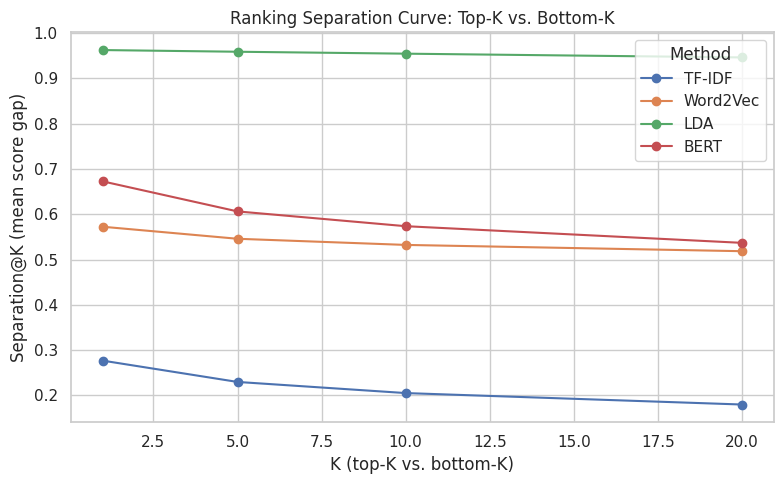

In [ ]:
# This evaluation method measures the difference between the average similarity scores of the top-K and bottom-K matched resumes for each job.
# A higher Separation@K indicates better performance in ranking relevant resumes higher than irrelevant ones.

def separation_at_k_matrix(sim_matrix, K=5):
    seps = []
    for sims in sim_matrix:
        order = np.argsort(sims)[::-1]
        topk = sims[order[:K]]
        botk = sims[order[-K:]]
        seps.append(topk.mean() - botk.mean())
    return np.mean(seps)

def separation_at_k_df(df, job_col, resume_col, score_col, K=5):
    seps = []
    for job, grp in df.groupby(job_col):
        sims = grp[score_col].values
        if len(sims) < 2*K:
            continue
        order = np.argsort(sims)[::-1]
        topk = sims[order[:K]]
        botk = sims[order[-K:]]
        seps.append(topk.mean() - botk.mean())
    return np.mean(seps)

similarity_matrix_bert = np.mean(list(sim_matrix_bert.values()), axis=0)
# --- 1) Compute Sep@5 & Sep@10 ---

methods = {
    'TF-IDF':  sim_matrix_tfidf,
    'Word2Vec': sim_matrix_word2vec,
    'LDA':      sim_matrix_lda,
    'BERT':     similarity_matrix_bert
}

results = []
for name, sims in methods.items():
    if isinstance(sims, np.ndarray):
        sep5  = separation_at_k_matrix(sims, K=5)
        sep10 = separation_at_k_matrix(sims, K=10)
    else:
        sep5  = separation_at_k_df(sims, 'job_id', 'res_id', 'score', K=5)
        sep10 = separation_at_k_df(sims, 'job_id', 'res_id', 'score', K=10)
    results.append((name, sep5, sep10))

df_sep = (
    pd.DataFrame(results, columns=['Method','Sep@5','Sep@10'])
      .sort_values('Sep@5', ascending=False)
      .reset_index(drop=True)
)

print("Separation@K Summary")
print(df_sep)

# --- 2) Plot Sep@K curve for multiple K values ---

Ks = [1, 5, 10, 20]
plt.figure(figsize=(8, 5))

for name, sims in methods.items():
    if not isinstance(sims, np.ndarray):
        # convert DataFrame‐style to matrix if needed
        sims = sims.pivot(index='job_id', columns='res_id', values='score').values
    curve = [separation_at_k_matrix(sims, K=k) for k in Ks]
    plt.plot(Ks, curve, marker='o', label=name)

plt.xlabel("K (top-K vs. bottom-K)")
plt.ylabel("Separation@K (mean score gap)")
plt.title("Ranking Separation Curve: Top-K vs. Bottom-K")
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.show()


### Unsupervised Evaluation Metric
Evaluate job-resume matching without ground truth using:
1. Cluster Agreement
2. Reciprocal Top-k Agreement
3. Mutual Rank Score

In [ ]:
## Unsupervised Evaluation Metrics
# These metrics evaluate the quality of the job-resume matching without relying on ground truth labels.
# Cluster Agreement: Measures how consistently top-ranked resumes for a job belong to the same cluster as the job.
# Reciprocal Top-k Agreement: Quantifies the mutual overlap in the top-k lists of jobs for a resume and resumes for a job.
# Mutual Rank Score: Calculates the average of the ranks assigned to mutually top-ranked job-resume pairs (lower is better).

# ------------------- HELPERS FUNCTION -------------------

def to_2d_float(X):
    """Safely converts sparse, dense, or nested inputs into a 2D float array."""
    if issparse(X):
        return X.toarray()

    if isinstance(X, dict):
        return np.hstack([to_2d_float(v) for v in X.values()])

    if isinstance(X, (list, tuple, np.ndarray)) and hasattr(X, '__getitem__'):
        try:
            if issparse(X[0]):
                return np.vstack([
                    x.toarray() if issparse(x) else np.asarray(x, dtype=float).reshape(1, -1)
                    for x in X
                ])
        except Exception:
            pass

        try:
            arr = np.asarray(X, dtype=float)
        except Exception:
            return np.vstack([
                x.toarray() if issparse(x) else np.asarray(x, dtype=float).reshape(1, -1)
                for x in X
            ])

        if arr.ndim == 1:
            return arr.reshape(1, -1)
        elif arr.ndim > 2:
            return arr.reshape(arr.shape[0], -1)
        return arr

    try:
        arr = np.asarray(X, dtype=float)
        if arr.ndim == 0:
            return arr.reshape(1, 1)
        if arr.ndim == 1:
            return arr.reshape(1, -1)
        return arr
    except Exception as e:
        raise ValueError(f"Cannot convert input to dense float array: {e}")

def l2_normalize_rows(X):
    """Row-wise L2 normalization with a small epsilon for stability."""
    X = to_2d_float(X)
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-9
    return X / norms

In [ ]:
# ------------------- 1. UNSUPERVISED METRICS -------------------

def cluster_and_retrieval_proxies(
    emb_job,
    emb_res,
    sim_matrix,
    k=5,
    n_clusters=5,
    pca_dim=50,
    random_state=42
):
    """
    Returns a dict containing:
      - cluster_agreement       : top-k within same cluster
      - reciprocal_agreement    : mutual top-k overlap
      - mutual_rank_score       : average of job/res ranks
    """
    # 1) normalize & densify similarity
    J = l2_normalize_rows(emb_job)
    R = l2_normalize_rows(emb_res)
    S = to_2d_float(sim_matrix)
    n_jobs, n_res = S.shape

    # 2) PCA projection of J+R
    combined = np.vstack([J, R])
    max_comp = min(combined.shape)
    n_comp = min(pca_dim, max_comp)
    C = PCA(n_components=n_comp, random_state=random_state).fit_transform(combined)

    # 3) cluster on PCA space
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = km.fit_predict(C)
    job_labels = labels[:n_jobs]
    res_labels = labels[n_jobs:]

    # 4) Cluster Agreement
    top_k_idx = np.argsort(-S, axis=1)[:, :k]
    agreement_scores = [
        np.mean(res_labels[top_k_idx[i]] == job_labels[i])
        for i in range(n_jobs)
    ]
    cluster_agreement = float(np.mean(agreement_scores))

    # 5) Reciprocal Agreement
    topk_jobs = np.argsort(-S, axis=1)[:, :k]
    topk_res  = np.argsort(-S, axis=0)[:k, :].T
    reciprocal = [
        np.mean([i in topk_res[r] for r in topk_jobs[i]])
        for i in range(n_jobs)
    ]
    reciprocal_agreement = float(np.mean(reciprocal))

    # 7) Mutual Rank Score
    job_rank = np.argsort(np.argsort(-S, axis=1), axis=1)
    res_rank = np.argsort(np.argsort(-S.T, axis=1), axis=1)
    mutual_ranks = []
    for i, topk in enumerate(topk_jobs):
        mr = [(job_rank[i, r] + res_rank[r, i]) / 2 for r in topk]
        mutual_ranks.append(np.mean(mr))
    mutual_rank_score = float(np.mean(mutual_ranks))

    return {
        "cluster_agreement":    cluster_agreement,
        "reciprocal_agreement": reciprocal_agreement,
        "mutual_rank_score":    mutual_rank_score
    }

# ------------------- 2. RUN METRICS FOR ALL MODELS ------------------

methods = {
    'TF-IDF':   (job_vecs_tfidf,       resume_vecs_tfidf,       sim_matrix_tfidf),
    'LDA':      (job_vecs_lda,         resume_vecs_lda,         sim_matrix_lda),
    'Word2Vec': (job_vecs_w2v,         resume_vecs_w2v,         sim_matrix_word2vec),
    'BERT':     (job_embeddings_bert,  resume_embeddings_bert,  similarity_matrix_bert)
}

results = {}
for name, (j_emb, r_emb, sim) in methods.items():
    results[name] = cluster_and_retrieval_proxies(
        emb_job=j_emb,
        emb_res=r_emb,
        sim_matrix=sim,
        k=10,
        n_clusters=5,
        pca_dim=50,
        random_state=42
    )

# ------------------- 3. DISPLAY RESULTS -------------------

print("\n=== Unsupervised Learning Metrics ===")
print(f"{'Model':<10} | {'ClusterAgree':<14} | {'Reciprocal':<10} | "
      f"{'MutualRank':<10}")
print("-" * 54)
for model_name, metrics in results.items():
    print(f"{model_name:<10} | "
          f"{metrics['cluster_agreement']:<14.4f} | "
          f"{metrics['reciprocal_agreement']:<10.4f} | "
          f"{metrics['mutual_rank_score']:<10.4f}")



=== Unsupervised Learning Metrics ===
Model      | ClusterAgree   | Reciprocal | MutualRank
------------------------------------------------------
TF-IDF     | 0.4936         | 0.5644     | 29.3272   
LDA        | 0.9368         | 0.7272     | 7.6976    
Word2Vec   | 0.5608         | 0.4028     | 34.0588   
BERT       | 0.9268         | 0.7716     | 5.9256    


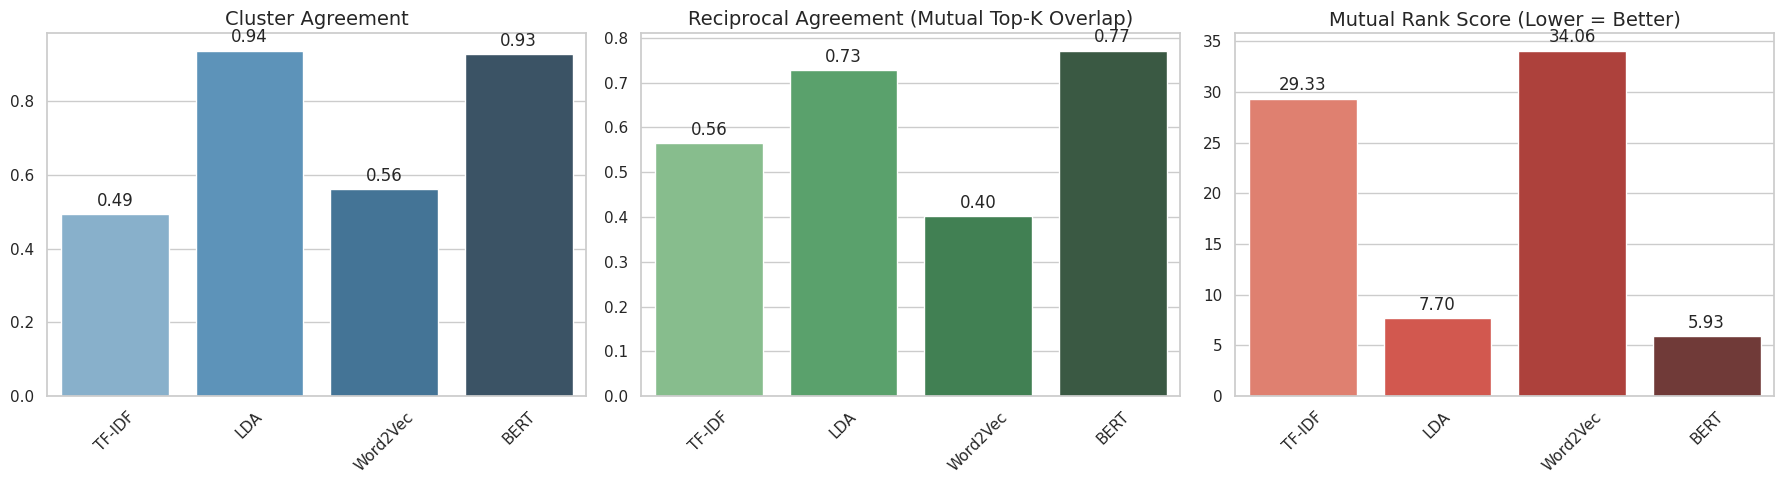

In [ ]:
# Create DataFrame from results
results_df = pd.DataFrame(results).T.reset_index().rename(columns={
    'index': 'Model',
    'cluster_agreement': 'Cluster Agreement',
    'reciprocal_agreement': 'Reciprocal Agreement',
    'mutual_rank_score': 'Mutual Rank Score'
})

# Set seaborn theme
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: Cluster Agreement
sns.barplot(data=results_df, x='Model', y='Cluster Agreement', ax=axes[0], hue='Model', palette='Blues_d', legend=False)
axes[0].set_title('Cluster Agreement', fontsize=14)
axes[0].set_ylabel('Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Reciprocal Agreement
sns.barplot(data=results_df, x='Model', y='Reciprocal Agreement', ax=axes[1], hue='Model', palette='Greens_d', legend=False)
axes[1].set_title('Reciprocal Agreement (Mutual Top-K Overlap)', fontsize=14)
axes[1].set_ylabel('Score')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Mutual Rank (lower is better)
sns.barplot(data=results_df, x='Model', y='Mutual Rank Score', ax=axes[2], hue='Model', palette='Reds_d', legend=False)
axes[2].set_title('Mutual Rank Score (Lower = Better)', fontsize=14)
axes[2].set_ylabel('Rank')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45)

# Final layout
for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()


### Visualizing Clusters with PCA

In [ ]:
# ## Evaluation: Visualizing Clusters with PCA
# This section visualizes the clusters created by each embedding method using Principal Component Analysis (PCA).
# PCA reduces the dimensionality of the embeddings to 2 components, allowing us to plot them on a 2D scatter plot.
# Each point represents a resume, and the color indicates the cluster assigned by KMeans.
# This visualization helps to qualitatively assess how well each method separates the resumes into distinct groups.

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Resume embeddings for each model
resume_embeddings = {
    'TF-IDF': resume_vecs_tfidf,
    'LDA': resume_vecs_lda,
    'Word2Vec': resume_vecs_w2v,
    'BERT': np.hstack([v for v in resume_embeddings_bert.values()]) # Concatenate BERT embeddings
}

pca = PCA(n_components=2, random_state=42)

# Apply PCA to each set of resume embeddings
resume_embeddings_2d = {}
for name, embeddings in resume_embeddings.items():
    # Convert sparse matrices to dense arrays for PCA
    if hasattr(embeddings, 'toarray'):
        embeddings = embeddings.toarray()
    resume_embeddings_2d[name] = pca.fit_transform(embeddings)

resume_cluster_dfs = {}

for name, embeddings_2d in resume_embeddings_2d.items():
    # Re-run KMeans on the 2D embeddings
    kmeans_2d = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels_2d = kmeans_2d.fit_predict(embeddings_2d)

    # Create DataFrame
    df = pd.DataFrame(embeddings_2d, columns=['PCA1', 'PCA2'])
    df['Cluster'] = labels_2d

    resume_cluster_dfs[name] = df

# Display the first few rows of the DataFrame for the first model as a check
if resume_cluster_dfs:
    first_model_name = list(resume_cluster_dfs.keys())[0]
    print(f"DataFrame for {first_model_name}:")
    display(resume_cluster_dfs[first_model_name].head())

DataFrame for TF-IDF:


,PCA1,PCA2,Cluster
0,0.220819,-0.067610,2
1,-0.137124,0.028880,1
2,0.331772,0.044492,0
3,0.081182,0.056291,3
4,-0.137124,0.028880,1


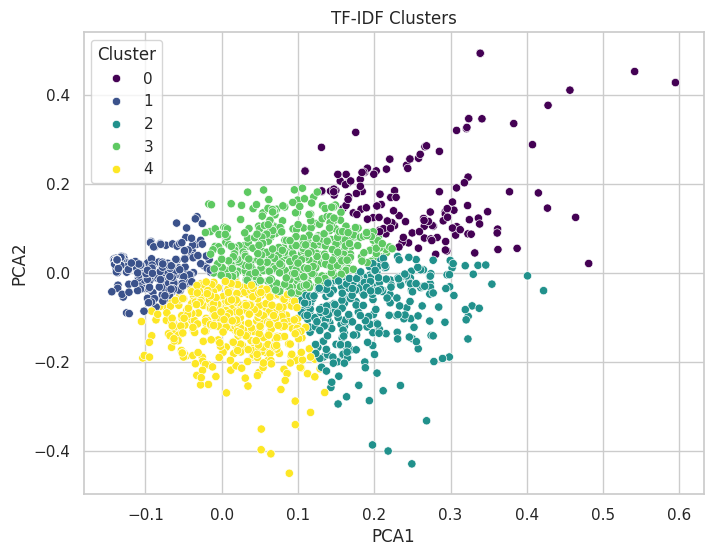

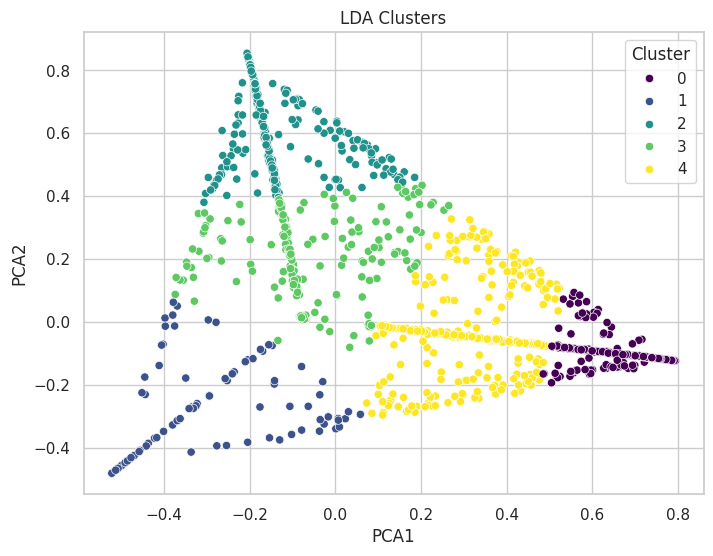

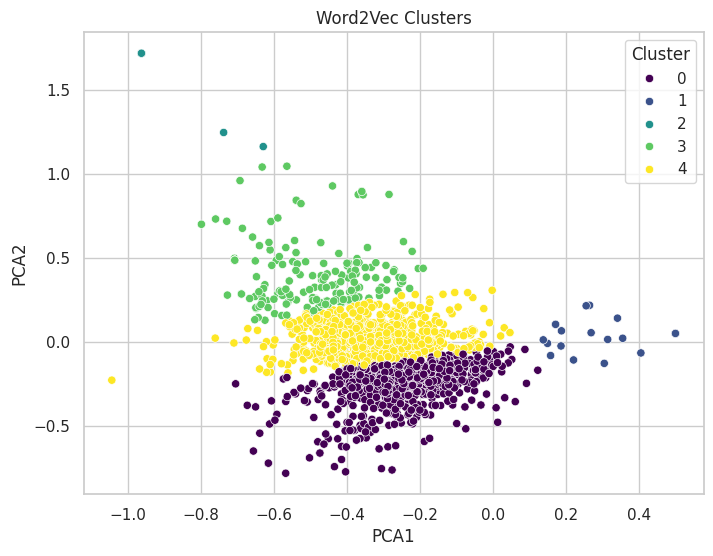

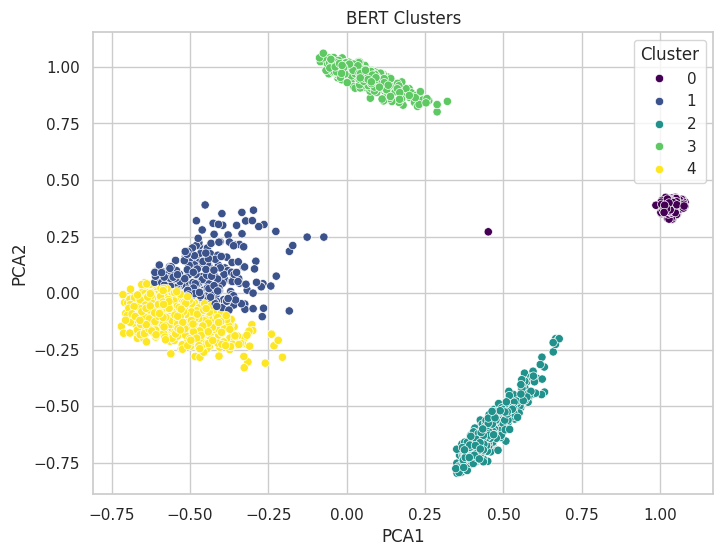

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for plots
sns.set(style="whitegrid")

# Iterate through the dataframes and create a scatter plot for each model
for name, df in resume_cluster_dfs.items():
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', legend='full')
    plt.title(f"{name} Clusters")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend(title="Cluster")
    plt.show()